# Описание проекта

В рамках проекта был получен датасет, отражающий фиксацию покупок пользователями интернет-магазина. Предполагается исследование полученных данных с целью выявления особенностей развития магазина. Основная задача - на базе имеющейся информации сегментировать покупателей, найти инсайты в полученных результатах и сформулировать рекомендации как по развитию магазина в целом, так и конкретные рекомендации по определенным категориям клиентов.

# Подготовка

## Импорт библиотек и чтение данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

In [2]:
#читаем основной датасет
data = pd.read_csv('/datasets/ecommerce_dataset.csv')

In [3]:
#регулируем параметры отображения таблиц так, чтобы длинные наименования вмещались в ячейки
#это будет полезно при изучении товаров
pd.set_option('display.max_columns', None)  
pd.options.display.max_colwidth = 150 

## Предобработка данных

### Общая характеристика "сырого" датасета

In [4]:
#посмотрим на данные
data.head(10)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
5,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0
6,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0
7,2018100108,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0
8,2018100108,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С614, 1404056",1,269.0
9,2018100109,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beige 130х50 см из хлопка 5379,1,674.0


In [5]:
#теперь посмотрим на характеристики непосредственно самой таблицы
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


В рамках предобработки предполагается выполнить следующие действия:

1. Проверить таблицу на наличие полных дубликатов
2. Привести тип в столбце `date` к типу даты из формата целого числа 


### Удаление дубликатов

In [6]:
#проверим таблицу на наличие полных дубликатов
print('Количество полных дубликатов в данных:', sum(data.duplicated()))

Количество полных дубликатов в данных: 0


Как видим, полных дубликатов в таблице нет. Данные, которые получаем, оценив первые 10 строк таблицы, мы можем сделать предположение, что поиск дубликатов по отдельным столбцам таблицы не имеет значения, так как они неизбежно будут обнаружены в силу логики хранения данных в таблице. 

### Приведение типов

Мы видим, что в столбце `date` данные хранятся в формате целого числа, что требует преобразование в формат даты. Однако также наблюдается вторая проблема - структура даты содержит избыточный фрагмент данных в конце строки. 

In [7]:
'''посчитаем среднее количество символов в ячейках столбца с датой
если число будет "ровным", то мы можем утверждать, что необычный формат записи даты - особенности хранения или 
экспорта данных'''

symbols = 0

for date in data['date']:
    symbols += len(str(date))

print('Среднее количество символов в столбцу с датой:', symbols / len(data))

Среднее количество символов в столбцу с датой: 10.0


Предположим, что последние две цифры - это час совершения заказа. Проверим гипотезу. 

In [8]:
#сформируем множество, куда запишем все уникальные комбинации последних двух цифр в строке
hours = set()

#при помощи цикла заполним множество значениями
for date in data['date']:
    string = str(date)
    hour = string[-2] + string[-1]
    hours.add(int(hour))

In [9]:
#посмотрим на множество
print(hours)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}


Можно утверждать, что гипотеза подтвердилась - в множество перечислены все возможные часы в сутках: от 0 до 23. С этой информацией можно поступить двумя возможными способами: 

1. Убрать часы и оставить только дату
2. Оставить час оформления заказа как дополнительный разрез - имея час совершения покупки мы имеем более гранулированные данные и можем получить больше инсайтов 

In [10]:
#преобразуем числов в формат даты
data['date']=pd.to_datetime(data['date'],format='%Y%m%d%H')

In [11]:
#предполагая, что далее потребуется изучение данных отдельно по разным уровням агрегации даты, 
#сформируем отдельные столбцы

data['order_hour'] = data['date'].dt.hour
data['order_day'] = data['date'].dt.day
data['order_week'] = data['date'].dt.week
data['order_weekday'] = data['date'].dt.dayofweek + 1
data['order_month'] = data['date'].dt.month
data['order_year'] = data['date'].dt.year
data['date'] = pd.to_datetime(data['date'].dt.date)

In [12]:
#посмотрим, что получилось
data.sample(5)

,date,customer_id,order_id,product,quantity,price,order_hour,order_day,order_week,order_weekday,order_month,order_year
1783,2019-02-11,f06909de-309a-4b59-b976-815f7ea2a57c,70208,Гладильная доска НИКА ЭЛЬЗА ДЕ ЛЮКС 122х40 см ЭЛ,1,1799.0,12,11,7,1,2,2019
6385,2019-09-21,6718a7fc-75c2-4b8a-820d-b2960be23ca7,14932,Рассада пряной травы Эвкалипт Сильвердроп в горшке d-9 см,2,52.0,21,21,38,6,9,2019
6729,2019-10-31,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.0,2,31,44,4,10,2019
1079,2018-12-03,2c8b9386-2e8c-4ee9-8aa4-2b4875b68578,14514,Пеларгония зональная диам. 12 см коралловая полумахровая,1,150.0,11,3,49,1,12,2018
1050,2018-12-02,1984005d-d793-4c5e-b21f-d2702f60ac4d,69167,"Сушилка для белья потолочная Лиана 2,4 м 1703011",1,734.0,8,2,48,7,12,2018


In [13]:
#проверим типы
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 12 columns):
date             6737 non-null datetime64[ns]
customer_id      6737 non-null object
order_id         6737 non-null int64
product          6737 non-null object
quantity         6737 non-null int64
price            6737 non-null float64
order_hour       6737 non-null int64
order_day        6737 non-null int64
order_week       6737 non-null int64
order_weekday    6737 non-null int64
order_month      6737 non-null int64
order_year       6737 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(8), object(2)
memory usage: 631.7+ KB


Мы видим, что теперь с типами данных все хорошо. 

### Обработка экстремумов

In [14]:
#посмотрим на цифры
data.describe()

,order_id,quantity,price,order_hour,order_day,order_week,order_weekday,order_month,order_year
count,6737.000000,6737.000000,6737.000000,6737.000000,6737.000000,6737.000000,6737.000000,6737.000000,6737.000000
mean,43128.948345,2.501559,462.028499,13.863589,14.530503,26.054475,3.718421,6.415764,2018.788927
std,27899.414662,15.266478,871.296064,4.969169,8.748617,13.191879,2.001738,3.035431,0.408100
min,12624.000000,1.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2018.000000
25%,14827.000000,1.000000,101.000000,10.000000,7.000000,17.000000,2.000000,4.000000,2019.000000
50%,68503.000000,1.000000,135.000000,14.000000,13.000000,23.000000,4.000000,6.000000,2019.000000
75%,70504.000000,1.000000,398.000000,18.000000,22.000000,40.000000,5.000000,9.000000,2019.000000
max,73164.000000,1000.000000,14917.000000,23.000000,31.000000,52.000000,7.000000,12.000000,2019.000000


Мы наблюдаем два выброса: 

1. По количеству - 1000 штук
2. По цене - 14917 условных единиц

Попробуем посмотреть, какие строки скрываются за этими цифрами. 

In [15]:
data[data['quantity'] > 899]

,date,customer_id,order_id,product,quantity,price,order_hour,order_day,order_week,order_weekday,order_month,order_year
5456,2019-06-18,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000",1000,675.0,15,18,25,2,6,2019


In [16]:
data[data['price'] == 14917]

,date,customer_id,order_id,product,quantity,price,order_hour,order_day,order_week,order_weekday,order_month,order_year
5992,2019-07-29,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400 40 м 175х237х237 см зеленая,1,14917.0,17,29,31,1,7,2019


Поиск этих товаров по наименованию показывает, что использованные цены близки к реальности, а также то, что в таблице указана стоимость 1 единицы товара. Таким образом, мы можем уже на данном этапе извлечь из полученных данных еще один разрез для анализа - получим общую стоимость строки по заказу (так, заодно, мы сможем извлечь данные по стоимости 1 заказа). 

In [17]:
#создаем дополнительный вычисляемый столбец
data['total'] = data['quantity'] * data['price']

In [18]:
#посмотрим на полученные цифры
data[data['quantity'] > 1].head()

,date,customer_id,order_id,product,quantity,price,order_hour,order_day,order_week,order_weekday,order_month,order_year,total
10,2018-10-01,161e1b98-45ba-4b4e-8236-e6e3e70f6f7c,68483,"Вешалка для брюк металлическая с резиновым покрытием 26 см цвет: синяя, Attribute, AHS331",10,82.0,11,1,40,1,10,2018,820.0
13,2018-10-01,0948b0c2-990b-4a11-b835-69ac4714b21d,68486,"Крючок одежный 2-х рожковый серый металлик с полимерным покрытием *Тонар*, 1110027",96,38.0,15,1,40,1,10,2018,3648.0
42,2018-10-02,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68493,"Щетка-сметка 3-х рядная деревянная 450 мм (плоская ручка), Поиск Риф 1801095",15,49.0,11,2,40,2,10,2018,735.0
43,2018-10-02,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68493,"Щетка-сметка 4-х рядная деревянная 300 мм (фигурная ручка) ворс 5,5 см 1801096",15,70.0,11,2,40,2,10,2018,1050.0
45,2018-10-02,9d05bf55-76d8-4efa-8617-435f92fe83f1,68504,"Тарелка обеденная ЛИМОН ФИЦ 25см, G9547, Luminarc, Франция",6,206.0,14,2,40,2,10,2018,1236.0


Теперь, располагая еще одним параметром, посмотрим на цифры по всему датафрейму еще раз. 

In [19]:
data.describe()

,order_id,quantity,price,order_hour,order_day,order_week,order_weekday,order_month,order_year,total
count,6737.000000,6737.000000,6737.000000,6737.000000,6737.000000,6737.000000,6737.000000,6737.000000,6737.000000,6737.000000
mean,43128.948345,2.501559,462.028499,13.863589,14.530503,26.054475,3.718421,6.415764,2018.788927,720.094998
std,27899.414662,15.266478,871.296064,4.969169,8.748617,13.191879,2.001738,3.035431,0.408100,8352.100591
min,12624.000000,1.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2018.000000,9.000000
25%,14827.000000,1.000000,101.000000,10.000000,7.000000,17.000000,2.000000,4.000000,2019.000000,120.000000
50%,68503.000000,1.000000,135.000000,14.000000,13.000000,23.000000,4.000000,6.000000,2019.000000,162.000000
75%,70504.000000,1.000000,398.000000,18.000000,22.000000,40.000000,5.000000,9.000000,2019.000000,600.000000
max,73164.000000,1000.000000,14917.000000,23.000000,31.000000,52.000000,7.000000,12.000000,2019.000000,675000.000000


In [20]:
#Наблюдается третий выброс. Посмотрим на него.
data[data['total'] > 100000]

,date,customer_id,order_id,product,quantity,price,order_hour,order_day,order_week,order_weekday,order_month,order_year,total
5456,2019-06-18,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000",1000,675.0,15,18,25,2,6,2019,675000.0


Наблюдаемое значение получено для строки, которая уже фигурировала в отборе. Вероятно, какой-то из клиентов единаразово закупил крупную партию товаров. На предыдущем шаге был произведен поиск этого товара в открытых источниках и в результате установлено, что указанная цена правдоподобна и соответствует 1 единице изделия. 

In [21]:
#попробуем посмотреть на структуру заказов данного конкретного клиента
data[data['customer_id'] == '312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6']

,date,customer_id,order_id,product,quantity,price,order_hour,order_day,order_week,order_weekday,order_month,order_year,total
5456,2019-06-18,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000",1000,675.0,15,18,25,2,6,2019,675000.0


Мы видим, что данный заказ был совершен единоразово. Вероятно, клиент, закупивший такую крупную партию однотипных изделий, не смог удовлетворить спрос у текущего поставщика. Маловероятно, что такое значение поможет нам в сегментировании пользователей, поэтому его имеет смысл убрать из анализируемого датасета в целях стабилизации значений мер центральной тенденции. Однако откидывать строки по идентификатору клиента будет непродуктивно, поэтому оставим в датасете строки до 99.99 процентиля. 

In [22]:
data = data[data['total'] < np.percentile(data['total'], 99.99)]

In [23]:
data.describe()

,order_id,quantity,price,order_hour,order_day,order_week,order_weekday,order_month,order_year,total
count,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000,6736.000000
mean,43124.700416,2.353474,461.996882,13.863420,14.529988,26.054632,3.718676,6.415825,2018.788895,619.994062
std,27899.306871,9.238065,871.356881,4.969519,8.749164,13.192853,2.001777,3.035652,0.408123,1500.616128
min,12624.000000,1.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2018.000000,9.000000
25%,14827.000000,1.000000,101.000000,10.000000,7.000000,17.000000,2.000000,4.000000,2019.000000,120.000000
50%,68503.000000,1.000000,135.000000,14.000000,13.000000,23.000000,4.000000,6.000000,2019.000000,162.000000
75%,70503.250000,1.000000,397.250000,18.000000,22.000000,40.000000,5.000000,9.000000,2019.000000,600.000000
max,73164.000000,334.000000,14917.000000,23.000000,31.000000,52.000000,7.000000,12.000000,2019.000000,49432.000000


Небольшой тюнинг позволил сократить среднее значение суммы по строке на 100 условных единиц без существенного изменения остальных значений. 

### Проверка корректности временного периода

In [24]:
print('Самая раняя дата:', np.min(data['date']))
print('Самая поздняя дата:', np.max(data['date']))
print('Количество дней в исследуемом периоде:', (np.max(data['date']) - np.min(data['date'])).days)

Самая раняя дата: 2018-10-01 00:00:00
Самая поздняя дата: 2019-10-31 00:00:00
Количество дней в исследуемом периоде: 395


В представленном датасете: 

1. Выбросы по датам не наблюдаются
2. Период составляет 395 дней (более 1 года)

# Исследовательский анализ данных

## Анализ временного периода

Как мы убедились ранее, временной период составляет 395, что более одного года, но незначительно. По этому причине сопоставить выручку, количество заказов или любые другие абсолютные значения будет некорректно, поэтому для начала мы посмотрим на следующие цифры цифры:

1. Средний чек (сумма по заказу)
2. Среднее количество заказов на 1 уникального клиента 
3. Средняя цена единицы товара 

In [25]:
#соберем сводный датафрейм, в который запишем метрики по году
y_to_y = data.groupby('order_year', as_index=False).agg(
    {
        'order_id': 'nunique',
        'product': 'count',
        'customer_id': 'nunique',
        'total': 'sum',
        'price': 'mean'
    })

y_to_y['orders_per_customer'] = y_to_y['order_id'] / y_to_y['customer_id'] #количество заказов на 1 покупателя
y_to_y['mean_cheque'] = y_to_y['total'] / y_to_y['order_id'] #средний чек
y_to_y['products_per_order'] = y_to_y['product'] / y_to_y['order_id'] #глубина чека
y_to_y = y_to_y[['order_year', 'price', 'orders_per_customer', 'mean_cheque', 'products_per_order']] 

In [26]:
y_to_y

,order_year,price,orders_per_customer,mean_cheque,products_per_order
0,2018,610.433896,1.221849,1643.331499,1.955983
1,2019,422.275875,1.105573,1445.263209,2.575860


1. Мы видим, что средняя цена единицы товара в 2019 году упала почти на треть, что довольно необычно, учитывая рыночную конъюнктуру. Средняя цена может означать:
    + Упала цена тех товаров, что мы продавали ранее - либо снизилась их себестоимость, либо упала наша маржа в силу каких-то факторов (например, конкурентная борьба)
    + Изменилась товарная матрица - мы стали продавать больше дешевых товаров 
2. Наблюдается снижение среднего количество заказов на 1 покупателя примерно на 9.5%:
    + Вполне возможно, что это подтверждение предположения о конкуретной борьбе - например, вариантов для приобритения одного и того же товара стало больше, поэтому стало меньше повторных заказов
3. Примерно на 12% упала сумма среднего чека, что логично на фоне значительного (примерно 31%) снижения средней цены 1 единицы товара
4. Наблюдается заметный рост глубины чека - около 32%
    + Становится понятна причина не столь заметного снижения среднего чека на фоне падения отпускной цены единицы товара - товары стали дешевле, но продаем мы больше
    + Эта цифра также выступает аргументом в пользу предположения об изменении товарной матрицы
    

**Выводы:**

1. Требуется изучение товарной матрицы
2. Требуется изучение паттернов покупательского поведения

In [27]:
#построим аналогичный датасет, снизившись на 1 уровень агрегации
m_to_m = data.groupby(['order_year', 'order_month'], as_index=False).agg(
    {
        'order_id': 'nunique',
        'product': 'count',
        'customer_id': 'nunique',
        'total': 'sum',
        'price': 'mean'
    })

m_to_m['orders_per_customer'] = m_to_m['order_id'] / m_to_m['customer_id'] #количество заказов на 1 покупателя
m_to_m['mean_cheque'] = m_to_m['total'] / m_to_m['order_id'] #средний чек
m_to_m['products_per_order'] = m_to_m['product'] / m_to_m['order_id'] #глубина чека
m_to_m = m_to_m[['order_year', 'order_month', 'price', 'orders_per_customer', 'mean_cheque', 'products_per_order']] 

In [28]:
m_to_m

,order_year,order_month,price,orders_per_customer,mean_cheque,products_per_order
0,2018,10,568.911817,1.320442,1760.476987,2.372385
1,2018,11,504.215190,1.145251,1810.634146,2.312195
2,2018,12,804.372703,1.191667,1408.279720,1.332168
3,2019,1,790.389381,1.089172,1665.035088,1.321637
4,2019,2,590.444965,1.164659,1191.220690,1.472414
5,2019,3,516.673307,1.046025,1280.072000,2.008000
6,2019,4,364.447197,1.116183,1419.758364,2.851301
7,2019,5,266.413594,1.062857,1649.161290,4.666667
8,2019,6,215.788530,1.044304,2495.036364,8.454545
9,2019,7,530.742500,1.064171,1389.683417,2.010050


На более низком уровне агрегации мы наблюдаем, что не все из выдвинутых предположений имеют под собой основание:

1. Значительно сниженные значения 2019 года объясняться сезонностью - вероятно, действительно наблюдается изменение товарной матрицы, но оно может носить циклический характер - вероятно, имеет смысл изучить уровень активности покупателей 
2. Так как в обоих датасетах мы располагаем полными данными о продажах октября, мы можем сопоставить два этих месяца

In [29]:
#сформируем датасет, куда запишем данные по октябрям 2018 и 2019 годов 

octobers = data[data['order_month'] == 10]
octobers = octobers.groupby(['order_year', 'order_day'], as_index=False).agg(
    {
        'order_id': 'nunique',
        'product': 'count',
        'customer_id': 'nunique',
        'total': 'sum',
        'price': 'mean'
    })

octobers['orders_per_customer'] = octobers['order_id'] / octobers['customer_id'] #количество заказов на 1 покупателя
octobers['mean_cheque'] = octobers['total'] / octobers['order_id'] #средний чек
octobers['products_per_order'] = octobers['product'] / octobers['order_id'] #глубина чека
#octobers = octobers[['order_year', 'price', 'orders_per_customer', 'mean_cheque', 'products_per_order']] 

#позднее при помощи статистических тестов мы сможем провести проверку,
#значимы ли отличия по метрикам двух сопоставих месяцев

In [30]:
#посмотрим на выручку по всем доступным месяцам в периоде
revenue_per_month = data.groupby(['order_year', 'order_month'], as_index=False).agg({'total': 'sum'})
revenue_per_month['time_marker'] = revenue_per_month['order_year'].astype('str') + '-' + revenue_per_month['order_month'].astype('str')

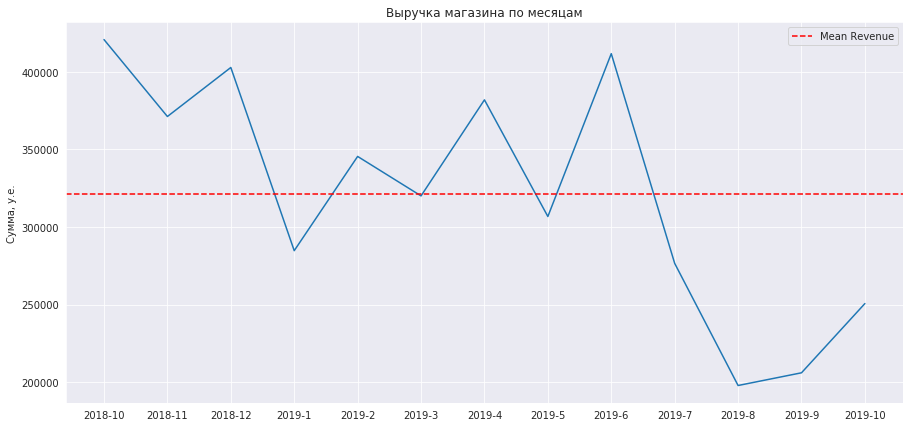

In [31]:
sns.set_style('darkgrid')

plt.figure(figsize=(15, 7))

plt.plot(revenue_per_month['time_marker'] , revenue_per_month['total'])
plt.axhline(y=revenue_per_month['total'].mean(), color='red', linestyle='--', label='Mean Revenue')
plt.title('Выручка магазина по месяцам', fontsize=12)
plt.ylabel('Сумма, у.е.', fontsize=10)

plt.legend(loc='best')

plt.show()

Наблюдаем: 

1. Закономерное падение выручки в январе - после сезона закупки новогодних празников
2. Далее наблюдается "отскок" и значения выше линии среднего до середины года
3. В период с 6 по 8 месяц наблюдаем падение выручки вдвое

Данных недостаточно для обоснованного прогнозирования тренда на будущее, но в таком виде график выглядит как подтверждение предположения об изменениях в структуре спроса.

In [32]:
#посмотрим на данные также в разрезе выручки и количества заказов по дням недели
weekday_revenue = data.groupby('order_weekday', as_index=False).agg({'total': 'sum', 'order_id': 'nunique'})
weekday_revenue['mean_cheque'] = weekday_revenue['total'] / weekday_revenue['order_id']

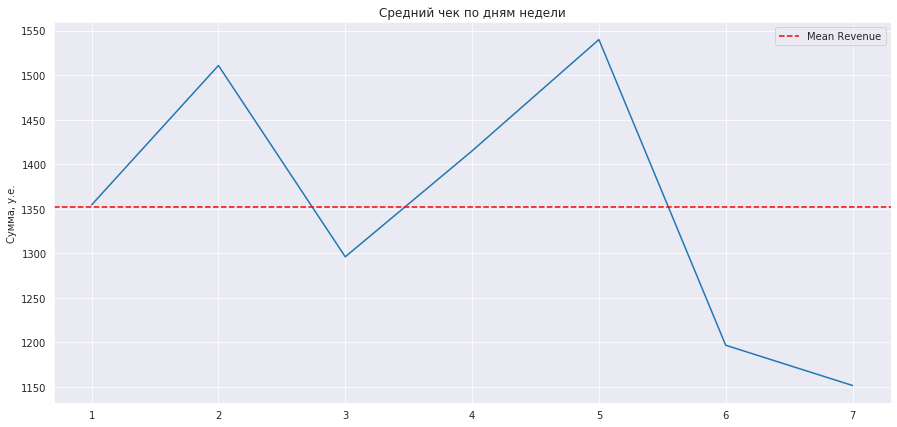

In [33]:
plt.figure(figsize=(15, 7))

plt.plot(weekday_revenue['order_weekday'] , weekday_revenue['mean_cheque'])
plt.axhline(y=weekday_revenue['mean_cheque'].mean(), color='red', linestyle='--', label='Mean Revenue')
plt.title('Средний чек по дням недели', fontsize=12)
plt.ylabel('Сумма, у.е.', fontsize=10)

plt.legend(loc='best')

plt.show()

Наблюдается:

1. Заметный рост суммы чека во вторник - вероятно, после понедельника клиенты понимают, чего не хвататет из ассортимента магазина и размещают заказ 
2. Еще больший скачок в пятницу - вероятно, это уже другая категория клиентов закупается чем-то перед выходными

**Выводы:** 

1. Есть предположение, что произошло изменение структуры спроса, что повлияло на экономику чека - мы сохранили данные по двум аналогичным периодам (октябрь) двух представленных лет для дальнейшего анализа в разрезе спроса и, возможно, последующей сегментации клиентов
2. Также заметны два паттерна спроса на графике изменения средней суммы чека по дням недели

## Анализ и сегментация покупателей

### Сегментация по покупательскому поведению

На базе имеющихся данных представляется разумным начать с изучения метрик доступных для каждого из клиентов. Наиболее очевидный шаг - изучить частоту покупок.

In [34]:
customers = data.groupby('customer_id', as_index=False).agg({'order_id': 'nunique', 'product': 'count', 'total': 'sum', 'date': 'min'})
#для расчета периода активности получим максимальную дату заказа
customers = customers.merge(data.groupby('customer_id', as_index=False).agg({'date': 'max'}), on='customer_id')
#получим количество уникальных дат по клиенту 
customers = customers.merge(data.groupby('customer_id', as_index=False).agg({'date': 'nunique'}), on='customer_id')
customers.columns=['customer_id', 'orders', 'products', 'revenue', 'date1', 'date2', 'unique_dates']
customers['activity_period'] = (customers['date2'] - customers['date1']).dt.days

Первая строка заказа выглядит необычно - мы видим, что клиент сделал всего 1 заказ, при этом его период активности - 210 дней, а количество уникальных дат заказа - 60. Можно предположить, что дата в датасете не совсем в полной мере является именно датой заказа, а скорее отражает время некой транзакции в рамках одного заказа.

Зафиксированный паттерн характерен с наибольшей долей вероятности для юридического лица, которое размещает заказ на большой количество продукции и выбирает его у поставщика в несколько итераций.

In [35]:
#добавим столбец куда запишем отношение количества уникальных дат к количеству уникальных заказов
#чем больше будет число в этом столбце, тем больше транзакций на 1 номер заказа у данного клиента
customers['dates_per_order'] = round((customers['unique_dates'] / customers['orders']), 2)

In [36]:
#добавим два измерения одного параметра для сегментирования - максимальный и минимальный час заказа
customers = customers.merge(
    data.pivot_table(index='customer_id', values='order_hour', aggfunc={'min', 'max'}).reset_index(), 
    on='customer_id',
    how='left'
)

customers = customers.rename(columns={'min': 'min_order_hour', 'max': 'max_order_hour'})

In [37]:
customers.sort_values('dates_per_order', ascending=False)

,customer_id,orders,products,revenue,date1,date2,unique_dates,activity_period,dates_per_order,max_order_hour,min_order_hour
832,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,1,60,65220.0,2019-04-01,2019-10-28,57,210,57.00,23,8
287,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,1,888,114750.0,2019-05-31,2019-06-22,22,22,22.00,22,0
1326,8c290149-ad54-4d7a-87a7-9386b36390ee,1,23,2024.0,2018-12-01,2018-12-30,15,29,15.00,22,0
1638,ae6940d3-a1c7-4997-8853-a5b8afc60d51,1,16,32382.0,2019-04-15,2019-06-05,11,51,11.00,22,0
1750,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,1,21,4788.0,2018-10-05,2018-11-16,7,42,7.00,19,0
...,...,...,...,...,...,...,...,...,...,...,...
877,5d566073-92e8-41d1-a2e6-d301ee5ab6d8,3,3,434.0,2019-01-26,2019-01-26,1,0,0.33,22,21
1010,6b0c6cfb-7717-4c34-8535-bbc6e2b2c758,3,3,660.0,2019-07-28,2019-07-28,1,0,0.33,15,14
2444,ff422162-fc4a-4b65-a0e2-17f5095ea2c6,3,3,1610.0,2019-03-11,2019-03-11,1,0,0.33,15,10
938,639c4989-b0ab-412a-b7ec-be394cb2d372,3,4,12095.0,2018-11-05,2018-11-05,1,0,0.33,22,2


В первой строке наблюдается некое отклонение от стандартной модели поведения - мы видим, что у клиента всего 1 заказ для которого в сете присутствуют 57 разных дат. Кроме того, период активности для этого клиента составляет 210 дней, что слишком много (субъективно) для оценки этого отклонения как ошибки, по этой причине удалять такие строки из датасета мы не будем. 

Однако в связи с такой аномалией, мы попробуем оценить поведение покупателей с точки зрения статистики заказов.

In [38]:
orders_stats = data.groupby('order_id', as_index=False).agg({'date': 'nunique', 'customer_id': 'nunique', 'total': 'sum'})

#проверим сет на наличие "аномалий" количества идентификаторов пользователей
orders_stats[orders_stats['customer_id'] > 1].sort_values('customer_id', ascending=False)

,order_id,date,customer_id,total
2609,72845,3,4,9440.0
902,69485,3,3,3635.0
1914,71480,3,3,222.0
248,14872,3,2,1122.0
1651,70946,2,2,268.0
2575,72790,2,2,4272.0
2568,72778,2,2,298.0
2268,72188,2,2,44.0
2004,71663,4,2,536.0
2000,71648,2,2,1408.0


In [39]:
print('Количество заказов с более чем 1 уникальным идентификатором пользователя:', len(orders_stats[orders_stats['customer_id'] > 1]))
print('Общая выручка по таким заказам:', orders_stats[orders_stats['customer_id'] > 1]['total'].sum())
print('-------')
print('Количество заказов с более чем 1 уникальной датой:', len(orders_stats[orders_stats['date'] > 1]))
print('Общая выручка по таким заказам:', orders_stats[orders_stats['date'] > 1]['total'].sum())

Количество заказов с более чем 1 уникальным идентификатором пользователя: 29
Общая выручка по таким заказам: 93678.0
-------
Количество заказов с более чем 1 уникальной датой: 190
Общая выручка по таким заказам: 867990.0


Так как мы не располагаем возможностью получить дополнительные данные о происхождении датасета, а также уточнить значение некоторых признаков, будем исходить из здравого смысла. 

1. Наличие нескольких дат логически объяснимо:
    + Предположительно, поле `date` содержит не дату заказу, а дату отражения некоторой транзакции, а также набор соответствующих признаков, зафиксированных в рамках этой транзакции - это косвенно подтверждается заказом с периодом активности в 210 дней. Обычно дата заказа в учетных системах остается неизменной, в том числе для корректного расчета метрик эффективности бизнес-процессов, поэтому будем отталкиваться от вышеизложенной гипотезы
    + Несколько дат для 1 заказа, соответственно, отражают постепенной выбор товара по заказу клиентом (частичная отгрузка/поставка)
2. В то же время, логическое объяснение нескольких разных ИД пользователей для 1 заказа более сложное - возможно, на уровне бизнес-процессов допускается отгрузка клиенту, отличному от того, который разместил заказ. Второе предположение - это ошибка на уровне обработки транзакций. 

Учитывая небольшое количество таких заказов, мы отбросим их из датасета. 

In [40]:
#сохраним список идентификаторов заказов, в которых более 1 клиента
dropped_orders = orders_stats[orders_stats['customer_id'] > 1]['order_id'].to_list()

#оставим в исходном датафрейме только те, у которых 1 клиент
data = data[~data['order_id'].isin(dropped_orders)]

#заодно оценим, как изменилось количество заказов с более чем 1 датой
orders_stats = data.groupby('order_id', as_index=False).agg({'date': 'nunique', 'customer_id': 'nunique', 'total': 'sum'})
print('Количество заказов с более чем 1 уникальной датой:', len(orders_stats[orders_stats['date'] > 1]))
print('Общая выручка по таким заказам:', orders_stats[orders_stats['date'] > 1]['total'].sum())

Количество заказов с более чем 1 уникальной датой: 165
Общая выручка по таким заказам: 777606.0


Для корректной оценки текущей ситуации мы разделим покупателей на 2 группы на верхнем уровне:

+ Покупатели, совершившие 1 заказ - фактически, это "случайные" покупатели. Они пришли в магазин за каким-то товаром однажды и, вероятно, не слишком лояльны
+ Покупатели, совершившие более 1 заказа - по каким-то причинам эта категория возвращается в магазин

In [41]:
orders_per_customer = data.groupby('customer_id', as_index=False).agg({'order_id': 'nunique'})\
.sort_values('order_id', ascending=False)

In [42]:
#присоединяем к строкам датафрейма данные о количество заказов покупателя
data = data.merge(orders_per_customer, on='customer_id', how='left')

In [43]:
data = data.rename(columns={'order_id_x': 'order_id', 'order_id_y': 'orders_per_customer'})

In [44]:
#функцией присвоим категорийную переменную каждому клиенту в каждой строке 
def grouper(row):
    if row['orders_per_customer'] == 1:
        row['orders_pattern'] = 'One order'
    else:
        row['orders_pattern'] = 'Multiple orders'
    return row

In [45]:
data = data.apply(grouper, axis=1)

In [46]:
data.head()

,date,customer_id,order_id,product,quantity,price,order_hour,order_day,order_week,order_weekday,order_month,order_year,total,orders_per_customer,orders_pattern
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,0,1,40,1,10,2018,142.0,1,One order
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,0,1,40,1,10,2018,194.0,1,One order
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,0,1,40,1,10,2018,112.0,1,One order
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,0,1,40,1,10,2018,179.0,1,One order
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,0,1,40,1,10,2018,112.0,1,One order


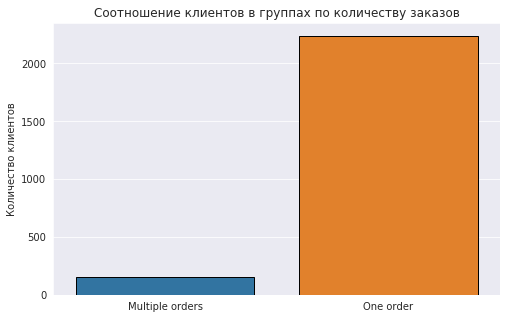

In [47]:
#построим график
plt.figure(figsize=[8, 5]) 

graph = sns.barplot(
    x='orders_pattern',
    y='customer_id',
    data=data.groupby('orders_pattern', as_index=False).agg({'customer_id': 'nunique'}),
    edgecolor = "black"
)

graph.set(
    title='Соотношение клиентов в группах по количеству заказов', 
    xlabel='',
   ylabel='Количество клиентов'
)

plt.show()

Мы видим, что по данному признаку клиенты разделились очень неравномерно. Однако такая картина выглядит не очень позитивно, так как только 6.5% клиентов вернулись к нам для совершения повторного заказа - из этого можно сделать предположение, что с точки зрения рынка наш магазин не предлагает клиентам ничего особенного и покупка скорее всего зачастую ситуативна.

Однако мы можем спуститься еще на один уровень в этом же направлении и разделить покупателей на группы по строк в заказе, но так как мы уже фиксировали в датасете несколько дат отгрузки для 1 заказа, то введем понятие "моно-заказ" под которым будем понимать следуюещее: 

1. В заказе 1 уникальный товар 
2. У заказа 1 уникальная дата

Предположение такое: одноразовый монозаказ - слабо прогнозируемое событие, поэтому преобладание таких заказов в структуре несколько усложняет работу по привлечению клиентов к совершению повторных покупок. 

In [48]:
#оформим введенную сущность в виде отдельного датафрейма и прикрепим результат в основной датасет
orders = data.groupby('order_id', as_index=False).agg({'product': 'count', 'date': 'nunique'}).sort_values('product')
orders['mono_order'] = ((orders['product'] + orders['date']) / 2).astype('int')
orders['is_mono_order'] = orders['mono_order'].apply(lambda x: 'Mono' if x == 1 else 'Multi')
orders = orders.drop(['date', 'mono_order'], axis=1)
orders = orders.rename(columns={'product': 'sku_in_order'})

In [49]:
data = data.merge(orders, on='order_id', how='left')

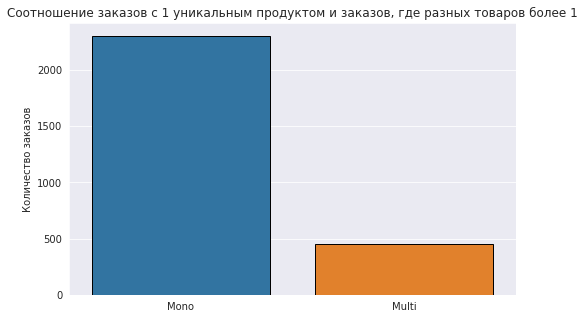

In [50]:
#построим график
plt.figure(figsize=[8, 5]) 

graph = sns.barplot(
    x='is_mono_order',
    y='order_id',
    data=data.groupby('is_mono_order', as_index=False).agg({'order_id': 'nunique'}),
    edgecolor = "black"
)

graph.set(
    title='Соотношение заказов с 1 уникальным продуктом и заказов, где разных товаров более 1', 
    xlabel='',
    ylabel='Количество заказов'
)

plt.show()

Таким образом, мы разделили покупателей на 4 группы по базовым метрикам поведения:

1. У покупателя 1 заказ на 1 товар - вероятно, это наименее перспективная группа, так как клиент был изначально заинтересован только в 1 товаре и совершил покупку всего один раз. Теоретически, это говорит о его низкой заинтересованности
2. У покупателя 1 заказ, но товаров более 1:
    + По аналогии с группой 1 покупатель "случайно" купил в магазине товары, но ему было необходимо купить более 1 наименования
    + Покупатель что-то по рекомендации продавца, либо предложений на сайте
3. У покупателя более заказа, но все на 1 товар - это более интересная группа с точки зрения потенциальных возможностей наращивания выручки, так как клиент систематически возвращается/возвращался за товаром - вероятно, его будет значительно проще заинтересовать другими товара и увеличить глубину чека и выручку
4. У покателя более 1 заказа и более 1 товара в заказах - это условная группа "лояльных" клиентов

In [51]:
#посмотрим на цифры выделенных категорий
initial_grouping = data.groupby(['orders_pattern', 'is_mono_order'], as_index=False).agg(
    {
        'order_id': 'nunique',
        'orders_per_customer': 'mean',
        'total': 'sum',
        'product': 'nunique',
        'price': 'mean',
        'order_weekday': 'median',
        'order_hour': 'median'
    }
)

initial_grouping['mean_cheque'] = initial_grouping['total'] / initial_grouping['order_id']
#initial_grouping = initial_grouping.drop(['sku_in_order'], axis=1)

initial_grouping

,orders_pattern,is_mono_order,order_id,orders_per_customer,total,product,price,order_weekday,order_hour,mean_cheque
0,Multiple orders,Mono,432,39.197368,573017.0,322,819.072368,3,12,1326.428241
1,Multiple orders,Multi,84,8.158203,123857.0,283,192.453125,3,13,1474.488095
2,One order,Mono,1871,1.000000,2308164.0,1249,858.949102,4,14,1233.652592
3,One order,Multi,367,1.000000,1077564.0,992,228.891156,4,14,2936.141689


**Выводы:**

1. Наибольшее количество заказов в категории 1 заказ-1 товар. Это, как мы установили ранее, наименее привлекательная категория, так как такие клиентык к нам не возвращаются и обычно покупают всего 1 товар. Такие клиенты генерируеют около 60% выручки - следует обратить внимание на среднюю цену 1 единицы товара в этой группе - она самая высокая среди всех категорий
2. Очевидна разница в среднем количестве заказов на 1 клиента в группах с более чем 1 заказом на клиента - мы видим, что покупатели с 1 товаров в заказе почти в 5 раз чаще делают заказы - при этом расхождение в количестве уникальных товарных позиций также наблюдается, но оне столько существенно (283 в мультигруппе и 322 в соло группе). Возможно, покупатели с 1 товаром в заказе "забывают" оформить нужный товар в процессе оформления одного заказа и возвращаются чуть позже за дополнительным
3. Около 25% выручки генерируют заказы клиентов, у которых всего 1 зарегистрированный заказ, но в этом заказе более 1 позиции. Это более интересная группа, так как они потенциально больше "подвержены" использованию механизма рекомендаций, а также их стоит рассмотреть для "конверсии" в потенциальных клиентов: изучить предпочтения, сделать предложения (программа лояльности, прокод и т.п.). Также обращает на себя внимание сумма среднего чека в этой группе - она более чем в 2 раза выше, чем чек любой другой группы 
4. Обращает на себя внимание также тот факт, что клиенты, у которых больше 1 заказа, сильнее сгруппированы в начале недели и первой половине дня - они предпочитают делать заказы пораньше 


**Рекомендации:**

1. Стоит изучить UI/UX процесса оформления заказа - возможно нет системы рекомендаций, либо она работает не совсем корректно
2. Стоит изучить источники, из которых приходят покупатели за 1 заказом с 1 товаром - возможно мы найдем что-то на сайтах конкурирующих магазинов. Также имеет смысл изучить, как работает наше продвижение - быть может оно неэффективно, недостаточно финансируется, либо стоит подключить какие-то дополнительные активности: акции, промо-коды и т.п.
3. Изучить ассортимент "ранних" заказов - возможно здесь также есть потенциал для роста

### Покупательское поведение + товарные сегменты

Попробуем немного углубиться внутрь уже обозначенных групп и сегментировать клиентов внутри них по предпочтительному ассортименту. Для этого сделаем "грубую" ручную категоризацию товаров по их наименованиям.

In [52]:
products = data.groupby('product', as_index=False).agg(
    {'total': 'sum', 'quantity': 'sum', 'order_id': 'nunique', 'customer_id': 'nunique'})

products['orders_per_customer'] = products['order_id'] / products['customer_id']

products['total_rank'] = products['total'].rank()
products['orders_rank'] = products['order_id'].rank()
products['customers_rank'] = products['customer_id'].rank()
products['overall_rank'] = products['total_rank'] + products['orders_rank'] + products['customers_rank']
products['norm_overall_rank'] = products['overall_rank'] / products['overall_rank'].max()

products.sort_values('overall_rank', ascending=False).head()

,product,total,quantity,order_id,customer_id,orders_per_customer,total_rank,orders_rank,customers_rank,overall_rank,norm_overall_rank
1611,Сумка-тележка 2-х колесная Gimi Argo синяя,65281.0,61,47,43,1.093023,2329.0,2327.0,2327.0,6983.0,1.000000
1035,Пеларгония розебудная Red Pandora укорененный черенок,11866.0,88,64,61,1.049180,2285.0,2330.0,2330.0,6945.0,0.994558
1010,Пеларгония зональная диам. 12 см сиреневый полумахровый,12284.0,71,52,47,1.106383,2288.0,2328.0,2328.0,6944.0,0.994415
992,Пеларгония зональная диам. 12 см красная махровая,12204.0,73,21,21,1.000000,2287.0,2319.5,2319.5,6926.0,0.991837
1033,Пеларгония розебудная Prins Nikolai укорененный черенок,9035.0,67,53,50,1.060000,2253.0,2329.0,2329.0,6911.0,0.989689


In [53]:
#при помощи функции составим рейтинг слов 
names = []
alphabet = ["а","б","в","г","д","е","ё","ж","з","и","й","к","л","м","н","о",
            "п","р","с","т","у","ф","х","ц","ч","ш","щ","ъ","ы","ь","э","ю","я"]

for product in products['product']:
    words = product.split(' ')
    for word in words:
        letters_list = word.strip()
        if len(word) <= 3:
            continue
        elif letters_list[-1] == 'я' and letters_list[-2] == 'а':
            continue
        elif letters_list[-1] == 'й' and letters_list[-2] == 'ы':
            continue
        elif letters_list[-1] == 'й' and letters_list[-2] == 'о':
            continue
        elif letters_list[0].isupper() and not letters_list[1].isupper() and letters_list[0].lower() in alphabet:
            names.append(word.lower())

In [54]:
rating = {i: names.count(i) for i in names}

In [55]:
rating2 = pd.DataFrame.from_dict(rating, orient='index').reset_index()
rating2.columns=['key_word', 'frequency']
#rating2['key_word'] = rating2.key_word.str.lower()
rating2 = rating2[rating2['frequency'] >= 5]

In [56]:
#выделим наиболее "яркие" категории и вручную их наполним ключевыми словами
plants = [
    "пеларгония",
    "роза",
    "петуния",
    "капусты",
    "герань",
    "цветок",
    "мята",
    "однолетнее",
    "калибрахоа",
    "флокс",
    "огурца",
    "цикламен",
    "примула",
    "букет",
    "вербена",
    "виолет",
    "капуста",
    "пуансеттия",
    "огурец",
    "лиана",
    "фуксия",
    "бегония",
    "тыквы",
    "гвоздика",
    "фиалка",
    "бакопа",
    "комнатное",
    "бальзамин",
    "розмарин",
    "петрушка",
    "дыня", 
    "космея",
    "кабачка",
    "сальвия",
    "спирелла",
    "хризантема",
    "виола",
    "антуриум",
    "лаванда",
    "тюльпан",
    "арбуза",
    "эвкалипт",
    "томат", 
    "тюльпан",
    "перец",
    "лобелия",
    "дыни",
    "азалия", 
    "мимоза", 
    "хризолидокарпус",
    "радермахера",
    "циперус",
    "шеффлера",
    "циперус",
    "юкка",
    "лавр",
    "мирт",
    "многолетнее",
    "каланхое",
    "дерево",
    "хлорофитум",
    "томат",
    "томата",
    "помидор",
    "декабрист",
    "спатифиллум",
    "арбуз",
    "мединилла",
    "тимьян",
    "колокольчик",
    "базилик", 
    "аптения",
    "овсянница",
    "папоротник",
    "фаленопсис",
    "ясколка",
    "эхеверия",
    "вербейник",
    "нивянник",
    "ромашка",
    "чабер",
    "калатея",
    "замляника",
    "цикламен",
    "цикламен,",
    "виноград",
    "камнеломка",
    "седум",
    "котовник",
    "гардения",
    "вероника",
    "душица",
    "лапчатка",
    "земляника",
    "кореопсис",
    "алоэ",
    "эпипремнум",
    "цитрофортунелла",
    "калла",
    "хоста",
    "эхинокактус",
    "тюльпаны",
    "ранункулус", 
    "нарцисс",
    "пахира",
    "драцена",
    "скиммия",
    "дендробиум",
    "гиацинты",
    "барвинок",
    "крокусы",
    "гортензия",
    "клен",
    "лилейник",
    "семена",
    "семя",
    "рассада",
    "саженец",
    "саженцы",
    "г"
]

hoz = [
    "сушилка",
    "сумка-тележка",
    "сумка",
    "чехол",
    "вешалка",
    "корзина",
    "стремянка",
    "тележка",
    "контейнер",
    "щетка",
    "лестница-стремянка",
    "полки",
    "швабра",
    "ведро",
    "карниз",
    "перчатки",
    "средство",
    "таз",
    "доска",
    "щетка",
    "щетка-сметка", 
    "ерш",
    "ёрш",
    "сиденье",
    "корыто",
    "подрукавник",
    "ящик",
    "вешалки",
    "урна",
    "стремянки",
    "веник",
    "стремянка-табурет",
    "вешалок",
    "урна-пепельница",
    "штанга",
    "комод",
    "вешалка-плечики",
    "подставка",
    "гладильной",
    "кофр", 
    "кашпо",
    "этажерка",
    "стеллаж", 
    "салфеток",
    "плечики",
    "термометр", 
    "полка",
    "инструментов",
    "нетканые",
    "скалка",
    "щетка-утюжок",
    "картонная",
    "бак",
    "сметка",
    "корзинка",
    "хранения",
    "гладильная",
    "вешалка-стойка",
    "обувница-3", 
    "короб",
    "вешалка-перекладина",
    "валик",
    "пуф",
    "щётка", 
    "вешалка-сушилка",
    "дозатор",
    "сетка",
    "прищепок",
    "окномойка",
    "ванна",
    "напильников",
    "насадка",
    "овощечистка",
    "совок",
    "коробка", 
    "подголовник", 
    "инструмент"
]

fabrics = ["полотенце", "простынь", "наматрацник", "наматрасник", "покрывало", "простыня", "наматрицник-чехол", "одеяло", "ткань", \
          "плед", "белье", "халат", "полотенец", "пододеяльник", "тряпка"]

posuda = [
    "скатерть",
    "тарелка",
    "чайник",
    "салатник", 
    "кружка", 
    "банка",
    "сковорода",
    "салфетка",
    "кастрюля"
    "термокружка",
    "ложка",
    "мини-сковорода",
    "сковороды",
    "нож",
    "вилка",
    "котел",
    "миска",
    "фужеров",
    "кексов",
    "ножницы",
    "кувшин",
    "ножей",
    "свч",
    "тepмокружка",
    "ковш",
    "хлебница",
    "Термокружка",
    "блюдце",
    "блюдо",
    "стакан",
    "alpenkok",
    "чугунная",
    "эмалированная",
    "tepмокружка",
    "столовых",
    "половник",
    "бокалов",
    "посуды",
    "чайный",
    "эмалированный",
    "отделитель",
    "тортница",
    "сотейник",
    "соуса",
    "емкость",
    "терка",
    "толкушка",
    "мантоварка",
    "термос",
    "кастрюля",
    "салатников",
    "яр-2406м",
    "стаканов"
]

tehnika = ["измельчитель", "овощеварка", "миксер", "пылесос", "электроштопор", "весы", "мантоварка-пароварка", "соковарка", "светильник",\
          "утюг", "фен"]

decor = ["муляж", "ковер", "коврик", "штора", "композиция", "ковёр", "декоративная", "ковров"]

krepezh = ["стяжка", "крепеж", "пружина", "крючок", "петля", "ручка-скоба", "шпингалет", "завертка", "фал", "уголок"]

chemistry = ["средство", "паста", "сварка", "бензин", "ополаскиватель", "мыло", "гель", "кондиционер", "соль", "увлажняющая"]

In [57]:
#при помощи функции сделаем категоризацию
def categorizer(row):
    product_split = row['product'].lower().split()
    for x in fabrics:
        if x in product_split:
            row['group'] = 'Текстиль'
        else:
            continue
    for x in tehnika:
        if x in product_split:
            row['group'] = 'Бытовые приборы'
        else:
            continue
    for x in chemistry:
        if x in product_split:
            row['group'] = 'Химия'
        else:
            continue
    for x in krepezh:
        if x in product_split:
            row['group'] = 'Крепеж'
        else:
            continue
    for x in decor:
        if x in product_split:
            row['group'] = 'Украшения для дома'
        else:
            continue
    for x in plants:
        if x in product_split:
            row['group'] = 'Растения'
        else:
            continue
    for x in hoz:
        if x in product_split:
            row['group'] = 'Хозяйственные принадлежности'
        else:
            continue
    for x in posuda:
        if x in product_split:
            row['group'] = 'Посуда'
        else:
            continue
    return row

In [58]:
data['group'] = 'TBD'

data = data.apply(categorizer, axis=1)

In [59]:
data['product'] = data['product'].str.lower()

In [60]:
data.groupby('group', as_index=False).agg({'total': 'sum', 'order_id': 'nunique', 'quantity': 'sum', 'product': 'nunique', 'customer_id': 'nunique'}).sort_values('total', ascending=False)

,group,total,order_id,quantity,product,customer_id
8,Хозяйственные принадлежности,2403083.0,1249,3626,703,1084
4,Растения,745711.0,824,6058,885,721
3,Посуда,354955.0,275,1768,275,252
6,Украшения для дома,322695.0,251,1907,182,226
5,Текстиль,131676.0,38,147,38,37
2,Крепеж,49757.0,25,1556,20,21
0,TBD,37739.0,155,340,194,147
1,Бытовые приборы,32470.0,25,31,19,23
7,Химия,4516.0,13,36,12,13


Товары без категории оставлены в группе "TBD" - при текущем уровне детализации она составляет менее 1% выручки и этого вполне достаточно для добавления еще признака в уже выделенные группы.

In [61]:
#data[data['group'] == 'TBD'].groupby(
    #'product', as_index=False).agg(
    #{'total': 'sum', 'order_id': 'nunique', 'customer_id': 'nunique'}).sort_values('total', ascending=False).head(20)

In [62]:
#посмотрим на цифры выделенных категорий
initial_grouping = data.groupby(['group', 'orders_pattern', 'is_mono_order'], as_index=False).agg(
    {
        'customer_id': 'nunique',
        'order_id': 'nunique',
        'total': 'sum',
        'product': 'nunique',
        'price': 'mean',
    }
)

initial_grouping['mean_cheque'] = initial_grouping['total'] / initial_grouping['order_id']

#посмотрим на результат, отбросив строки, содержащие менее 0,5% выручки, для простоты восприятия
initial_grouping[initial_grouping['total'] > 0.005*initial_grouping['total'].sum()].sort_values('total', ascending=False)

,group,orders_pattern,is_mono_order,customer_id,order_id,total,product,price,mean_cheque
32,Хозяйственные принадлежности,One order,Mono,922,922,1564202.0,536,1326.544799,1696.531453
33,Хозяйственные принадлежности,One order,Multi,98,98,443869.0,138,950.445813,4529.275510
18,Растения,One order,Multi,236,236,439250.0,631,125.299515,1861.228814
30,Хозяйственные принадлежности,Multiple orders,Mono,60,215,351200.0,158,1310.752252,1633.488372
25,Украшения для дома,One order,Mono,177,177,226083.0,120,688.243386,1277.305085
13,Посуда,One order,Mono,202,202,207775.0,186,544.342593,1028.589109
17,Растения,One order,Mono,414,414,198123.0,249,236.881838,478.557971
14,Посуда,One order,Multi,33,33,78761.0,65,226.190000,2386.696970
19,Текстиль,Multiple orders,Mono,5,6,71251.0,5,1451.666667,11875.166667
16,Растения,Multiple orders,Multi,37,65,64950.0,233,123.303529,999.230769


1. Первую позицию по выручке занимает группа "Хозяйственные принадлежности", в которой клиенты совершили 1 заказ в исследуемом периоде, а в заказе было не более 1 позиции. Магазин обработал 922 таких заказа. Эта категория перспективна, так как клиенты сгенерировали 35-40% всей выручки магазина, поэтому ее стоит рассмотреть в качестве потенциального источника лояльных клиентов, готовых возвращаться в магазин
2. На второй строчке по объему сгенерированной выручки мы наблюдаем также категорию "Хозяйственные принадлежности", клиенты в которой также совершили по 1 заказу в исследуемом периоде, однако в данном случае в заказах более 1 позиции. Тем не менее, выручка этой группы в 3.5 раза меньше предыдущей - текущее положение магазина сложно охарактеризовать как "надежное", так как 49.2% выручки получено за счет всего 1 товарной категории и клиентов с одинаковым паттерном в 1 заказ за исследуемый период
3. На третьей позиции мы наблюдаем категорию "Растения", ассортимент которой, как было установлено в процессе разметки номенклатуры на категории, наиболее "однородный" и крайне многочисленный (количество уникальных SKU), однако мы видим, что даже при этих условиях выручка от категории клиентов 
4. Группы на позициях 4, 5, 6 выделены отдельно, но технически эти группы можно называть болеее низким уровнем агрегации категории "Хозяйственные принадлежности", хотя при разметке выявить отличие было несложно на уровне здравого смысла 
5. Обращает на себя внимание ширина ассортимента в категории "Растений" и средняя стоимость 1 изделия - в этих группах продается много разных товаров, зачастую в больших количествах при низкой средней стоимости изделия (в 6 и более раз 1 единица товара дешевле, чем в группе хозтоваров)
6. При анализе групп нетрудно заметить 3 системные проблемы, требующих дальнейшего решения:
    + Клиенты предпочитают совершать 1 заказ и не возвращаться в магазин
    + Клиенты предпочитают приобретать всего 1 товар в чеке
    + Из этого вытекает, что продажи в магазине довольно жестко разделены на два стрима, субъективно которые можно разделить следующим образом:
        - Растения, семена, рассада и связанное 
        - Хозяйственные принадлежности, техника, посуда и т.д. 

**Рекомендации:**

1. Провести углубленное исследование поведения покупателей в группах сопоставим по признакам товарной категории и количества совершенных заказов, но с более чем 1 товаров в чеке. Для этого рекомендуется детализировать категоризацию товаров для достоверного определения группы товаров-референсов.
2. Рекомендуется произвести комплексное исследование покупательского поведения - представленные сегменты говорят о том, что на сайте либо не работает, либо работает крайне плохо система рекомендаций
3. Рекомендуется пересмотреть в целом стратегию магазина - для начала стоит провести углубленное исследование финансовых потоков, так как магазин должен работать с максимальным синергитическим эффектом между подразделениями, что на данный момент не наблюдается

In [63]:
#проверим предположение о низком уровне пересечения категорий в заказах
groups_crossing = data.groupby('order_id', as_index=False).agg({'group': 'nunique', 'total': 'sum'}).sort_values('group', ascending=False)
groups_crossing = groups_crossing[groups_crossing['group'] > 1]
groups_crossing

,order_id,group,total
681,69090,5,2109.0
403,68610,5,2324.0
449,68682,4,1615.0
605,68941,4,2111.0
501,68760,4,50770.0
...,...,...,...
622,68965,2,993.0
523,68805,2,1686.0
349,68531,2,2998.0
242,14863,2,7356.0


Как видим, при верхнеуровневой группировке наблюдаются всего 78 заказов из 2754 (около 3%). 
При этом, выручка таких заказов составляет 239386 условных единиц из 4082602 (около 6%). 

# Проверка гипотез

## Среднее количество заказов в день снизилось в 2019 году в сравнении с 2018 годом

Ранее было выдвинуто предположение о том, что в 2019 году произошло сокращение ряда показателей в числе которых и среднее количество заказов. Проверим эту гипотезу при помощи статистистических методов. 

В соответствии с правилами формулирования гипотез:

- **Нулевая гипотеза (H₀): Среднее количество заказов в день в октябре 2018 года не изменилось относительно аналогичного значения 2019 года**
- **Альтернативная гипотеза (H₀): Среднее количество заказов в октябре 2018 года отличается от аналогичного значения 2019 года**

In [64]:
#для проверки гипотезы воспользуемся дата-фреймом, который мы сформировали ранее
octobers

,order_year,order_day,order_id,product,customer_id,total,price,orders_per_customer,mean_cheque,products_per_order
0,2018,1,11,20,11,13934.0,479.300000,1.000000,1266.727273,1.818182
1,2018,2,15,43,12,26643.0,523.883721,1.250000,1776.200000,2.866667
2,2018,3,8,11,7,10574.0,890.909091,1.142857,1321.750000,1.375000
3,2018,4,11,28,10,26579.0,816.571429,1.100000,2416.272727,2.545455
4,2018,5,7,14,7,4720.0,196.142857,1.000000,674.285714,2.000000
...,...,...,...,...,...,...,...,...,...,...
57,2019,27,3,5,3,998.0,99.800000,1.000000,332.666667,1.666667
58,2019,28,8,10,8,9072.0,460.400000,1.000000,1134.000000,1.250000
59,2019,29,3,3,2,642.0,214.000000,1.500000,214.000000,1.000000
60,2019,30,12,12,11,7809.0,607.333333,1.090909,650.750000,1.000000


In [65]:
#для использования статистического критерия сформируем две выборки
octobers_2018 = octobers[octobers['order_year'] == 2018]
octobers_2019 = octobers[octobers['order_year'] == 2019]

Так как мы предполагаем, что будет произведено сравнение двух независимых выборок для количественных данных, то предполагаем использование Т-критерия Стьюдента, однако предварительно проведем тест нормальности распределения количества заказов по дням тестом Шапиро-Уилка.

Statistics=0.969, p-value=0.486
Принять гипотезу о нормальности


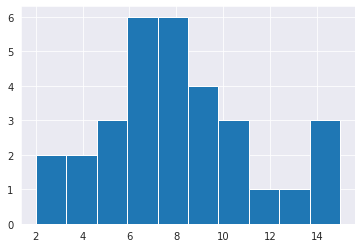

In [66]:
stat, p = st.shapiro(octobers_2018['order_id'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')
    
octobers_2018['order_id'].hist()
plt.show()

Statistics=0.877, p-value=0.002
Отклонить гипотезу о нормальности


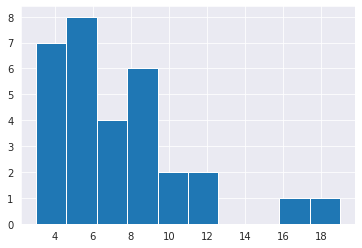

In [67]:
stat, p = st.shapiro(octobers_2019['order_id'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')
    
octobers_2019['order_id'].hist()
plt.show()

Наблюдаем любопытный эффект - уже на этапе проверки распределения признака в выборках наблюдается серьезное отличие. Строго говоря, нам необходимо использовать другой критерий, однако сделаем допущение о том, что нормальность распределения признака в одном из периодов позволяет нам использовать критерий для нормально распределенных выборок. 

In [68]:
alpha = 0.05 #зададим критический уровень статистической значимости в 5%

results = st.ttest_ind(
    octobers_2018['order_id'], 
    octobers_2019['order_id'],
    equal_var=False) #предполагаем, что дисперсии не равны

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.330276877294553
Не получилось отвергнуть нулевую гипотезу


In [69]:
print('Отношение среднего количества заказов в 2019 году к 2018 году:', octobers_2019['order_id'].mean() / octobers_2018['order_id'].mean())

Отношение среднего количества заказов в 2019 году к 2018 году: 0.892430278884462


In [70]:
octobers_2018['order_id'].mean()

8.096774193548388

In [71]:
octobers_2019['order_id'].mean()

7.225806451612903

Таким образом, мы не можем говорить о наличии статистически значимых различий в количестве заказов, несмотря на видимые отличия в цифрах (среднее количество заказов в день для 2019 года составляет лишь 87.5% от аналогичного в 2018 году). 

## Средний чек в октябре 2018 года изменился относительно аналогичного периода 2019 года

Установлено, что изменение количества заказов в день не имеет статистически значимых различий, однако мы предполагали также, что изменилась выручка, а именно - выручка с 1 заказа в 2019 году стала меньше вследствие неких изменение в структуре ассортимента.

In [72]:
#пересоберем датафрейм немного по-другому
octobers = data[data['order_month'] == 10].groupby(['order_year', 'order_id'], as_index=False).agg({'total': 'sum', 'quantity': 'sum'})
octobers_2018 = octobers[octobers['order_year'] == 2018]
octobers_2019 = octobers[octobers['order_year'] == 2019]

В соответствии с правилами формулирования гипотез:

- **Нулевая гипотеза (H₀): Средний чек в октябре 2018 года равен среднему чеку в октябре 2019 года**
- **Альтернативная гипотеза (H₀): Средний чек в октябре 2018 года статистически значимо отличается от среднего чека 2019 года**

Сделаем проверку на нормальность и по результатам используем подходящий тест - в данном случае данные распределены отлично от нормального, поэтому также используем непараметрический тест. 

Statistics=0.311, p-value=0.000
Отклонить гипотезу о нормальности


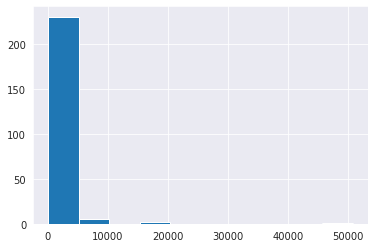

In [73]:
stat, p = st.shapiro(octobers_2018['total'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')
    
octobers_2018['total'].hist()
plt.show()

Statistics=0.693, p-value=0.000
Отклонить гипотезу о нормальности


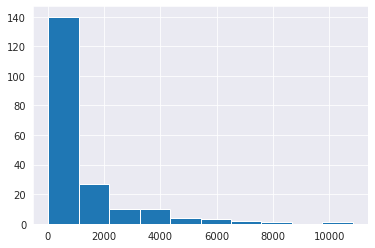

In [74]:
stat, p = st.shapiro(octobers_2019['total'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')
    
octobers_2019['total'].hist()
plt.show()

In [75]:
#проводим тест Манна-Уитни 
results = st.mannwhitneyu(
    octobers_2018['total'],
    octobers_2019['total']
)

#задаем критический уровень статистической значимости 
alpha = 0.05

print('Такое же или большее отличие между группами может быть получено случайно с вероятностью {:.2f}%'.format(p*100))

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Такое же или большее отличие между группами может быть получено случайно с вероятностью 0.00%
Отвергаем нулевую гипотезу


In [76]:
#оценим масштаб бедствия
print('Средний чек в октябре 2019 года сократился на {0:.1f}%'.format((1 - (octobers_2019['total'].mean() / octobers_2018['total'].mean()))*100))

Средний чек в октябре 2019 года сократился на 31.6%


## Клиенты, совершающие повторные заказы, размещают заказ раньше как в течение суток, так и в течение недели

В процессе работы с данными было зафиксировано интересное наблюдение - пользователи с повторными заказами обычно делают покупки раньше тех, кто заказывает всего 1 раз. Можем предположить, что "постоянные" покупатели заранее планируют свою покупку, поэтому и обрабатывают ее раньше. 

В соответствии с правилами формулирования гипотез:

- **Нулевая гипотеза (H₀): Нет статистически значимых отличий во времени размещения заказа для групп, состоящих из постоянных и "одноразовых" покупателей**
- **Альтернативная гипотеза (H₀): Статистически значимая разница во времени размещения заказа есть**

In [77]:
#посмотрим на средние значения (благо, что переменные в числовом типе данных)
data.groupby('orders_pattern').agg({'order_hour': 'mean', 'order_weekday': 'mean'})

,order_hour,order_weekday
orders_pattern,,
Multiple orders,13.290289,3.234504
One order,13.956154,3.798380


Технически, мы будем анализировать не количественные, а категорийные переменные, коими является и час и день недели, поэтому используем наиболее критерий Манна-Уитни.

In [78]:
#проводим тест Манна-Уитни 
results = st.mannwhitneyu(
    data[data['orders_pattern'] == 'One order']['order_weekday'],
    data[data['orders_pattern'] == 'Multiple orders']['order_weekday']
)

#задаем критический уровень статистической значимости 
alpha = 0.05

print('Такое же или большее отличие между группами может быть получено случайно с вероятностью {:.2f}%'.format(p*100))

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Такое же или большее отличие между группами может быть получено случайно с вероятностью 0.00%
Отвергаем нулевую гипотезу


In [79]:
#проводим тест Манна-Уитни 
results = st.mannwhitneyu(
    data[data['orders_pattern'] == 'One order']['order_hour'],
    data[data['orders_pattern'] == 'Multiple orders']['order_hour']
)

#задаем критический уровень статистической значимости 
alpha = 0.05

print('Такое же или большее отличие между группами может быть получено случайно с вероятностью {:.2f}%'.format(p*100))

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Такое же или большее отличие между группами может быть получено случайно с вероятностью 0.00%
Отвергаем нулевую гипотезу


Обе гипотезы отвергнуть не получилось, поэтому будем говорить о том, что постоянные клиенты предпочитают совершать заказы раньше как в течение недели, так и в течение дня. 

## Структура заказов претерпела изменения, поэтому упал средний чек заказа

Данное предположение мы проверим построением соответствующего датафрейма. 

In [80]:
#построим датафрейм, в котором сгруппируем количество и выручку по выделенным ранее категориям
data[data['order_month'] == 10].pivot_table(
    index='group',
    columns='order_year',
    values=['total', 'quantity'],
    aggfunc='sum'
).reset_index()

group quantity            total          
order_year                                   2018   2019      2018      2019
0                                    TBD     24.0   10.0    4032.0    1216.0
1                        Бытовые приборы      3.0    NaN    3447.0       NaN
2                                 Крепеж    845.0  234.0   25489.0    6980.0
3                                 Посуда    209.0   52.0   34676.0    6595.0
4                               Растения    246.0  255.0   35808.0   25863.0
5                               Текстиль     10.0    7.0   17330.0    8853.0
6                     Украшения для дома    186.0   72.0   36240.0   14554.0
7                                  Химия      4.0    2.0     207.0      88.0
8           Хозяйственные принадлежности    529.0  226.0  262777.0  174957.0

Технически, для более конкретного обсуждения результатов анализа нам потребуется значительно больший временной период (более одного месяца). Субъективно, от 1 года, так как такой период включит все возможные циклы. Плюс не помешает более точная выгрузка с разделением исследумой номенлкатуры на группы.

Располагая текущим объемом данных, мы получили два инсайта:

1. Сокращение как в штучной, так и в денежном выражении произошло со всеми категориями
2. Единственная категория в которой значений даже больше аналогично для 2018 года - это "Растения". Однако даже в этой группе сократилась выручка. 

Из этого мы можем сделать предположение, что некие внешние факторы влияют на лояльность клиентов и мы наблюдаем отток. 

# Выводы и рекомендации

**Выводы:**
1. Выявлено, что экономические показатели магазина снижаются:
    + С октября по декабрь 2018 года выручка находилась выше среднего значения для исследуемого датасета (около 320 тысяч)
    + В период с января по июнь 2019 выручка концентрировалась ближе к линии среднего с пиками в апреле и июне
    + Можно было бы предположить, что резкое падение в начале 2019 года - эффект сезонности, однако значения выручки для двух аналогичных сезонных периодов (октябрь) имееют разрыв порядка 40% (около 250 тысяч в октябре 2019 года и 415 в октябре 2018 годов)
2. В процессе сегментации аудитории пользователи изначально были разделены на две группы,
    + "Лояльные" клиенты, совершившие более 1 заказа - `Multiple orders`
    + "Эпизодические" клиенты, совершившие только 1 покупку в исследуемом периоде - `One order`
3. Исходя из предположения о том, что клиенты с несколькими заказами в периоде более интересны магазину, как источник более стабильного потока выручки, а также как источник информации для кастомизации предложении, был проведен анализ количества клиентов и прочих метрик в двух категориях:
    + Установлено, что в исследуемом периоде только 6.5% клиентов относятся к лояльным, что немного по субъективной оценке
    + Однако следует учесть, что даже эта немногочисленная аудитория условно лояльна, так как медианное значение количества заказов - 2 и только 17% постоянных клиентов совершают 3 или более заказов
4. Внутри групп по паттерну заказа было выделено по две группы по глубине чека:
    + Одна позиция в чеке - `Mono`
    + Более 1 позиции в чеке - `Multi`
5. Установлено, что порядка 84% всех заказов содержат всего 1 товар в чеке. При этом соотношение для "постоянных" и "эпизодических" клиентов идентично и составляет пропорцию 16%/84%.
6. В процессе анализа номенклатуры в транзакция датасета установлено, что верхнеуровнево магазин генерирует выручку за счет двух крупных стримов: 
    + Растения (семена, растения в горшках, рассада и прочее)
    + Хозяйственные товары (включая инструменты, бытовые принадлежности и прочее)
7. Крайне важен факт, что эти два стрима "расслоены" - около 3% заказов в датасете включают пересекающиеся категории (зачастую за счет отдельно выделенных категорий, которые также можно агрегировать до 1 уровня)
8. С точки зрения выручки наиболее интересные группы пользователей (последние 2 можно агрегировать до 1 уровня): 
    + Хозяйственные принадлежности/One order/Mono - 38.3%
    + Хозяйственные принадлежности/One order/Multi - 10.9%
    + Растения/One order/Multi	- 10.8%
    + Хозяйственные принадлежности/Multiple orders/Mono - 8.6%
    + Украшения для дома/One order/Mono	- 5.5%
9. Не удалось отвергнуть гипотезу о том, что количество заказов в день в октябре 2018 и 2019 годов не имеет статистически значисых отличий
10. Установлено, что между средним чеком октября 2018 и 2019 годов есть статистически значимые отличия. Средний чек в октябре 2019 года сократился на 31%
11. Установлено, что постоянные клиенты размещают свои заказы раньше как в течение недели, так и в течение суток. Предполагается, что это следствие планирования покупки
12. При субъективном изучении матрицы проданных товаров в октябре 2018 и 2019 годов не обнаружено значимых отличий - по всем категориям наблюдается снижение выручки, однако по категории "Растения" это наблюдается без сокращения количества проданного товара - стоит присмотреться к маржиналости этой группы

**Рекомендуется:**
1. Провести исследование качества работы с лояльными клиентами
2. Изучить механизм конверсии покупателей в постоянные
3. Изучить предпочтения "постоянных" покупателей и получить ответ на вопрос: "Что вынуждает их заказывать у нас?" - так будет возможно установить признаки ЦА при текущем ассортименте и сервисе
4. Рекомендуется провести анализ чеков, генерируемых аудиторией. Предположительно, существуют следующие проблемы:
    + Недофинансирование промоушена, либо его отсутствие, либо его некорректная работа
    + Некорректно работает система рекомендаций дополнительных товаров, либо она отсутствует
    + Также в процессе разметки справочника номенклатуры появилось предположение, что мастер-данные внутри КИС требуют валидации и, возможно, дополнения данными о товарах-референсах/субститутах
5. Провести анализ товарной матрицы:
    + Маржинальность отдельных позиций, чеков по группам и в целом категорий 
    + Возможность расширения товарной матрицы для наращивания выручки за счет "перспективных" групп пользователей и категорий номенклатуры
6. Так как основная масса аудитории на текущий момент предпочитает ограничиваться 1 заказом, то стоит рассмотреть:
    + Промоушен для "новых" клиентов - скидка/карта лояльности/промокод
    + Следующий шаг - конверсия их в постоянных клиентов
7. Провести бенчмаркинг конкурентов (цены, товарная матрица, акции)
8. Так как "эпизодические" клиенты скорее всего совершают более спонтанные покупки, стоит поискать способ утилизировать эту "спонтанность"